In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential,losses,mixed_precision
from tensorflow.keras.layers import Dropout, Dense, Conv2D, MaxPooling2D, Flatten,RandomFlip,RandomRotation,RandomZoom,RandomTranslation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import numpy as np
import os

In [3]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)  # Enable XLA
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]  # Limit GPU memory usage
            )
            print(f"Memory limit set for GPU\n")
    except RuntimeError as e:
        print(e)

In [ ]:
# Before training
print("\nXLA Status Check:")
print(f"XLA JIT enabled: {tf.config.optimizer.get_jit()}")
print(f"XLA devices: {tf.config.list_logical_devices('XLA_GPU')}")

In [6]:
data_dir = '/tf-acno-projects/image-classification/faces_data'

In [7]:
# 1. First analyze class distribution
def get_class_distribution(dataset):
    class_counts = tf.zeros(5, dtype=tf.int32)  # Assuming 5 classes
    
    for _, labels in dataset:
        class_counts += tf.cast(tf.reduce_sum(labels, axis=0), tf.int32)
    
    return class_counts.numpy()

In [8]:
def prepare_dataset(ds, batch_size, shuffle_buffer=1000, shuffle=True):
    # Preprocess images and labels
    ds = ds.map(lambda x, y: (
        tf.cast(x, tf.float32) / 255.0,  # Normalize images
        y
    ), num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(shuffle_buffer)
    
    # Use flat_map if your dataset comes pre-batched
    ds = ds.flat_map(lambda x, y: tf.data.Dataset.from_tensor_slices((x, y)))
    
    # Use padded_batch if you need padding
    ds = ds.padded_batch(
        batch_size,
        padded_shapes=([128,128,3], [5]),
        drop_remainder=False
    )
    
    return ds.prefetch(AUTOTUNE)

In [78]:
def plot_training_history(train_acc,val_acc,train_loss,val_loss):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

In [79]:
data_augmentation = Sequential([
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomFlip("horizontal"),
    RandomTranslation(0.1, 0.1)
])

def create_model(input_shape):
    regularization_value = 0.0001    
    model = Sequential([
       #data_augmentation,
       Conv2D(8,(3,3),
              strides=1,
              activation='relu',
              kernel_regularizer=l2(regularization_value),
              input_shape=input_shape),
       MaxPooling2D(),
       Dropout(0.20),  
       
       Conv2D(16,(3,3),
              strides=1,
              activation='relu',
              kernel_regularizer=l2(regularization_value)),
       MaxPooling2D(),
       Dropout(0.30),  
                     
       Flatten(),
       Dense(32,
              activation='relu',
              kernel_regularizer=l2(regularization_value)),
       Dropout(0.40),
       Dense(5,
              activation='softmax',
              dtype='float32')
       ])

    return model

In [80]:
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(128, 128),
    label_mode='categorical'  # Ensure labels are one-hot encoded
)

Found 4640 files belonging to 5 classes.


In [81]:
# Check class names and indices
class_names = dataset.class_names
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}, Index: {i}\n")

Class: angry, Index: 0

Class: disgusted, Index: 1

Class: happy, Index: 2

Class: sad, Index: 3

Class: shocked, Index: 4



Class: angry, Index: 0

Class: disgusted, Index: 1

Class: happy, Index: 2

Class: sad, Index: 3

Class: shocked, Index: 4

In [82]:
DATASET_SIZE = tf.data.experimental.cardinality(dataset).numpy()
# Define the sizes of your splits
train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = DATASET_SIZE - train_size - val_size

In [83]:
# Split the dataset
train_dataset = dataset.take(train_size) # takes 80% of the dataset
remaining = dataset.skip(train_size) # skips the first 80% means here we have the 20%
val_dataset = remaining.take(val_size) # First 10% of the remaining 20%
test_dataset = remaining.skip(val_size) # take the next 10% from the 20% remaining before

In [84]:
# Get distribution
train_dist = get_class_distribution(train_dataset)
print("\nClass distribution in training set:")
for i, count in enumerate(train_dist):
    print(f"Class {i}: {count} samples")

# Calculate class weights
total_samples = sum(train_dist)
n_classes = len(train_dist)
class_weights = {
    i: total_samples / (n_classes * count) if count> 0 else 0
    for i, count in enumerate(train_dist)
}

print("\nClass weights:")
for class_idx, weight in class_weights.items():
    print(f"Class {class_idx}: {weight:.2f}")


Class distribution in training set:
Class 0: 1209 samples
Class 1: 396 samples
Class 2: 978 samples
Class 3: 528 samples
Class 4: 601 samples

Class weights:
Class 0: 0.61
Class 1: 1.87
Class 2: 0.76
Class 3: 1.41
Class 4: 1.24


In [86]:
callbacks = [
    ModelCheckpoint("best_model.keras", monitor="val_loss", mode="min", save_best_only=True),
    EarlyStopping(monitor="val_loss", mode="min", patience=10),
    ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.2, patience=5)
]

In [ ]:
input_shape = (128,128,3)
batch_sizes = [8,16,32,64]
learning_rates = [0.001,0.0001,0.00001]
Epochs = 150
results = []

for batch_size in batch_sizes:
    # Configure datasets with current batch size
    train_ds = prepare_dataset(train_dataset, batch_size)
    val_ds = prepare_dataset(val_dataset, batch_size, shuffle=False)
    
    for lr in learning_rates:
        tf.keras.backend.clear_session()
        optimizer = Adam(learning_rate=lr)
        loss_scaling_optimizer = mixed_precision.LossScaleOptimizer(optimizer)
        
        model = create_model(input_shape)
        model.compile(
            optimizer=loss_scaling_optimizer,
            loss=losses.categorical_crossentropy,
            metrics=['accuracy'])
        
        history = model.fit(train_ds,
                            epochs=Epochs,
                            validation_data=val_ds,
                            class_weight=class_weights,  # Add class weights here
                            callbacks=callbacks,
                            verbose=0)
        
        # Evaluate on validation set
        val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
        
        results.append({
            'batch_size': batch_size,
            'learning_rate': lr,
            'val_accuracy': val_accuracy,
            'val_loss': val_loss,
            'history':history.history
        })

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-10-29 13:42:16.865127: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8563118607319860151
2024-10-29 13:42:16.865213: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10796714144715825565
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-29 13:42:17.655811: I tensorflow/

In [ ]:
display(HTML("<h1 style='color: red;'>Execution complete! 🎉</h1>"))
display(HTML("<h1 style='color: green;'>Execution complete! 🎉</h1>"))
display(HTML("<h1 style='color: blue;'>Execution complete! 🎉</h1>"))
display(HTML("<h1 style='color: yellow;'>Execution complete! 🎉</h1>"))


Best parameters:
Batch Size: 8
Learning Rate: 0.001
Validation Accuracy: 0.6183
Validation Loss: 1.1399


/tmp/ipykernel_9/3259434894.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_9/3259434894.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


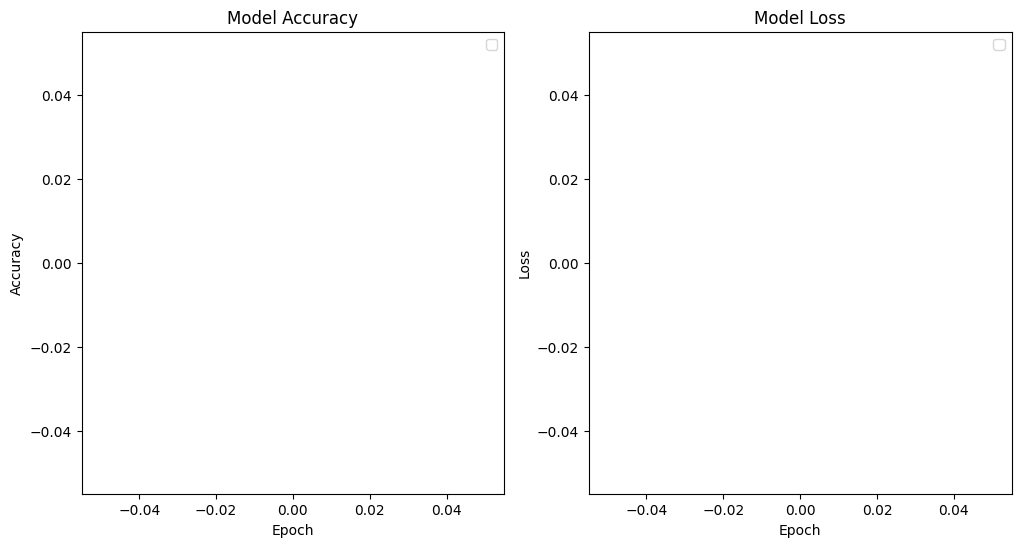

In [77]:
# find best parameters
best_result = max(results, key=lambda x: x['val_accuracy'])
best_result_hist = best_result['history']

print("\nBest parameters:")
print(f"Batch Size: {best_result['batch_size']}")
print(f"Learning Rate: {best_result['learning_rate']}")
print(f"Validation Accuracy: {best_result['val_accuracy']:.4f}")
print(f"Validation Loss: {best_result['val_loss']:.4f}")


# plot of the training accuracy and loss
plot_training_history(best_result_hist['accuracy'],
                    best_result_hist['val_accuracy'],
                    best_result_hist['loss'],
                    best_result_hist['val_loss'],
                    )

In [13]:
# Train final model with best parameters
tf.keras.backend.clear_session()

final_model = create_model(input_shape)
final_model.compile(optimizer=Adam(learning_rate=best_result['learning_rate']),
                    loss=losses.categorical_crossentropy,
                    metrics=['accuracy'])

In [ ]:
final_train_batches = prepare_dataset(train_dataset, best_result['batch_size'])
final_val_batches = prepare_dataset(val_dataset, best_result['batch_size'], shuffle=False)

final_history = final_model.fit(final_train_batches,
                                epochs=100,  # You might want to increase epochs for final training
                                validation_data=final_val_batches,
                                callbacks=callbacks)


In [16]:
train_loss = final_history.history['loss']
val_loss = final_history.history['val_loss']
train_acc = final_history.history['accuracy']
val_acc = final_history.history['val_accuracy']

plot_training_history(train_acc,val_acc,train_loss,val_loss)

In [ ]:
# Evaluate on test set
final_test_batches = prepare_dataset(test_dataset, best_result['batch_size'], shuffle=False)
test_loss, test_accuracy = final_model.evaluate(final_test_batches)
print(f"\nFinal Test Accuracy: {test_accuracy:.4f},Final Test Loss: {test_loss:.4f}")

Final Test Accuracy: 0.9250,Final Test Loss: 0.1644


In [23]:
final_model.save(os.path.join('/tf-acno-projects/image-classification/models','emotions_5_class_model_28-10.keras'))